In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd

from glob import glob
from shutil import move
from pprint import pprint
from tqdm import tqdm#_notebook as tqdm

from models.MikkelAE import MikkelAE
from models.BaseModel import BaseModel

from utils import plot, check_memory_usage
from myOrigDataLoader import myDataLoader

import matplotlib
import matplotlib.pyplot as plt

%matplotlib nbagg
%matplotlib inline

cuda = torch.cuda.is_available()
cuda

True

In [3]:
def get_model_called(model_name, params):
    model_fps = glob('/home/rob/Dropbox/thesis/2. code/src/models/*.py')
    model_names = [os.path.basename(fp).split('.')[0] for fp in model_fps]
    model_names.remove('__init__')
    if model_name == '':
        print(model_names)
        return False
    if model_name in model_names:
        exec(f'from models.{model_name} import {model_name}',globals())
        exec(f'model = {model_name}(**{params})',globals())
        return model
    else:
        return False

def get_loss_function_called(loss_name):
    assert loss_name in loss_function_dict.keys(), f"loss function {loss_name} not found, valid options: {loss_function_dict.keys()}"
    return loss_function_dict[loss_name]

def get_optimizer_called(opt_name, netparams, hparams):
    assert opt_name in optimizer_dict.keys(), f"optimizer {opt_name} not found, valid options: {optimizer_dict.keys()}"
    return optimizer_dict[opt_name](netparams, **hparams)

(20, 2)


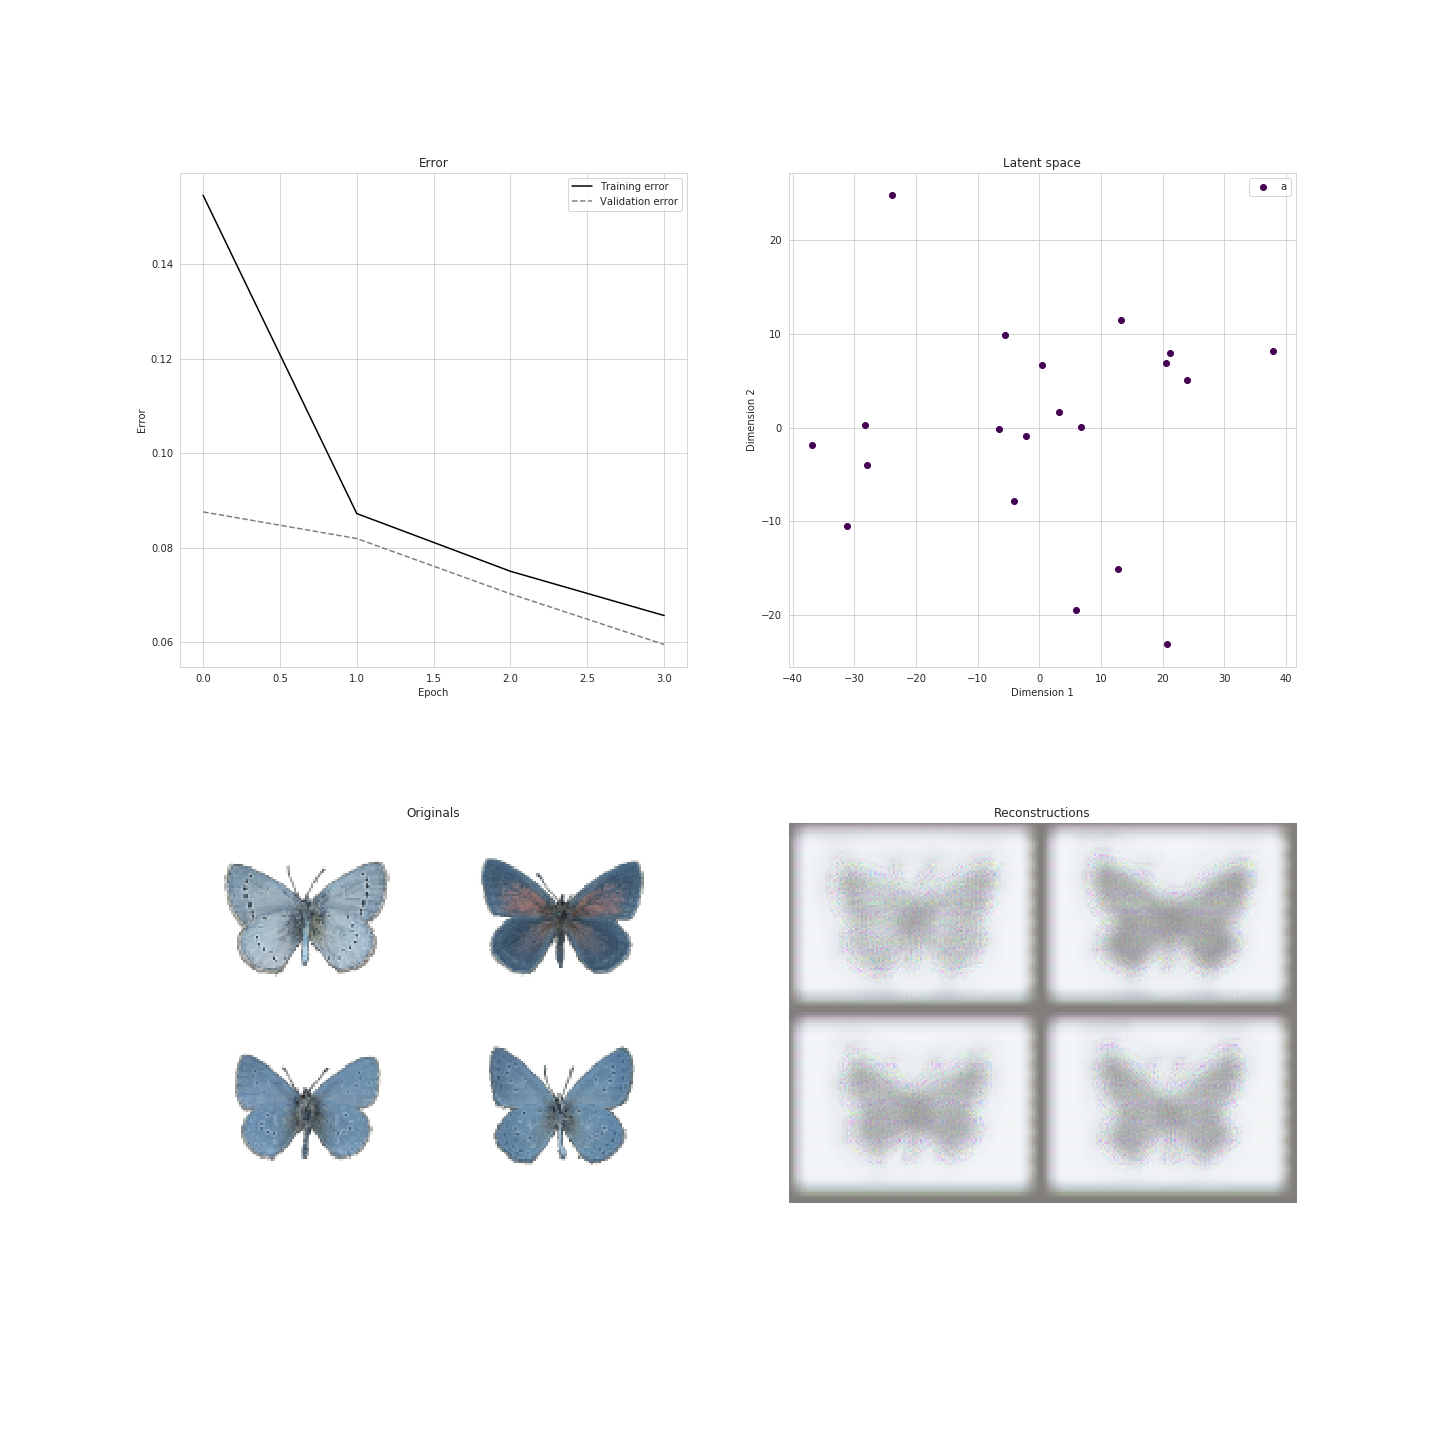

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy
from torch.autograd import Variable

def mse_loss(outputs):
    return F.mse_loss(outputs['x'],outputs['x_hat'])

def elbo_loss(outputs):
    # Reconstruction error, log[p(x|z)]
    # Sum over features
    likelihood = -binary_cross_entropy(outputs['x'], outputs['x_hat'], reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    ELBO = torch.mean(likelihood) - torch.mean(kl)
    
    # notice minus sign as we want to maximise ELBO
    return -ELBO, kl.sum()

loss_function_dict = {
    'mse': mse_loss,
    'elbo': elbo_loss
}
optimizer_dict = {
    'adam': optim.Adam,
    'sgd': optim.SGD
}

class experiment:
    def __init__(self,
                 modelName='',
                 modelParams = dict(),
                 loss = 'mse',
                 opt = 'adam',
                 optParams = dict(lr=0.0001),
                 sides = 'both',
                 imgSize = (240,160),
                 batchSize = 20,
                 datasets = ['international','copenhagen','aarhus'],
                 earlyStopping = 5,
                 max_num_epochs = 100,
                 cuda = True):
                
        self.modelFolder = '/home/rob/Dropbox/thesis/2. code/src/experiments'
        assert os.path.exists(self.modelFolder), "Cannot find model folder, abort!"
            
        self.modelName = modelName
        self.modelParams = modelParams
        
        self.loss = loss
        
        self.opt = opt
        self.optParams = optParams
        
        self.sides = sides
        self.imgSize = imgSize
        self.batchSize = batchSize
        self.datasets = datasets
        
        self.earlyStopping = earlyStopping
        self.max_num_epochs = max_num_epochs
        
        self.cuda = cuda
        self.date = pd.Timestamp.now().date()

        self.configuration = dict(
            modelName = modelName,
            modelParams = modelParams,
            loss = loss,
            opt = opt,
            optParams = optParams,
            sides = sides,
            imgSize = imgSize,
            batchSize = batchSize,
            datasets = datasets,
            earlyStopping = earlyStopping,
            max_num_epochs = max_num_epochs,
            cuda = cuda,
        )
        
        self.results = dict(
            avg_epoch_duration = None,
            date = self.date,
            epochs = None,
            best_valid_loss = None,
            train_losses = None,
            valid_losses = None,
            stopped_early = False,
        )
        
        self.prep_experiment()
        
    def prep_experiment(self):
        self.loader = myDataLoader(batchSize=self.batchSize, imgSize=self.imgSize, sides=self.sides, datasets=self.datasets)
        self.net = get_model_called(self.modelName, params=self.modelParams)
        if self.cuda:
            self.net = self.net.cuda()
        self.loss_function = get_loss_function_called(self.loss)
        self.optimizer = get_optimizer_called(self.opt, netparams=self.net.parameters(), hparams=self.optParams)
        
    def test_experiment(self):
        print('Testing data throughput...')
        batch = self.loader.getNext()
        
        x = Variable(torch.from_numpy(batch.imgs).float())
        x = x.permute((0,3,1,2))
        print('Input shape: ',x.shape)
        if self.cuda:
            x = x.cuda()

        outputs = self.net(x)
        print('Output shape: ',outputs['x_hat'].shape)
        assert outputs['x_hat'].shape == x.shape
        print('Test Successful.')
        return True
    
    def train(self):
        self.net.train()
        self.loader.trainSet()
        _, numBatches = self.loader.getIteratorInfo()
        
        avg_loss = 0
        for i in range(numBatches):
            batch = self.loader.getNext()
            x = Variable(torch.from_numpy(batch.imgs).float())
            x = x.permute((0,3,1,2))
            if self.cuda:
                x = x.cuda()

            self.optimizer.zero_grad()
            outputs = self.net(x)
            outputs['x'] = x
            x_hat = outputs['x_hat']

            loss = self.loss_function(outputs)

            loss.backward()
            self.optimizer.step()

            avg_loss += loss.item()/numBatches

        return avg_loss
        
    def validate(self):
        # Evaluate, do not propagate gradients
        self.loader.validationSet()
        _, numBatches = self.loader.getIteratorInfo()
        with torch.no_grad():
            self.net.eval()

            avg_loss = 0
            for i in range(numBatches):
                # Just load a single batch from the test loader
                batch = self.loader.getNext()
                x = Variable(torch.from_numpy(batch.imgs).float())
                x = x.permute((0,3,1,2))

                if self.cuda:
                    x = x.cuda()

                outputs = self.net(x)
                outputs['x'] = x

                loss = self.loss_function(outputs)

                avg_loss += loss.item()/numBatches
                
        return batch, outputs, avg_loss
    
    def run_experiment(self):
        print('Running Experiment with Configuration: ')
        pprint(self.configuration)
        
        best_val_loss = float('inf')
        noImprovementSince = 0
        train_losses = []
        valid_losses = []
        self.avg_epoch_duration = pd.Timedelta(0)
        
        for epoch in range(self.max_num_epochs):
            start_time = pd.Timestamp.now()
            train_loss = self.train()
            train_losses.append(train_loss)
            
            batch, outputs, valid_loss = self.validate()
            valid_losses.append(valid_loss)

            edur = pd.Timestamp.now() - start_time
            self.avg_epoch_duration = (self.avg_epoch_duration*(epoch) + edur)/(epoch+1)
            print(self.avg_epoch_duration)
            
            if valid_loss < best_val_loss:
                best_val_loss = valid_loss
                noImprovementSince = 0
                fp = os.path.join(self.modelFolder,self.modelName+'.pth.tar')
                print('Model Improved, saving model.')
                self.results = dict(
                    avg_epoch_duration = self.avg_epoch_duration,
                    date = self.date,
                    epochs = epoch,
                    best_valid_loss = best_val_loss,
                    train_losses = train_losses,
                    valid_losses = valid_losses,
                    stopped_early = True if epoch == self.max_num_epochs - self.earlyStopping else False,
                )
                
                self.net.save({
                    'configuration':self.configuration,
                    'results':self.results,
                    'state_dict':self.net.state_dict(),
                    'optimizer_dict':self.optimizer.state_dict()},fp)
            else:
                noImprovementSince += 1

            if epoch == 0:
                continue

            print(epoch, '/', self.max_num_epochs)
            batch = [outputs['x'], ['a']*(outputs['x'].size()[0])]
            plot(train_losses,valid_losses,outputs,batch,epoch,self.batchSize, self.cuda)

            if noImprovementSince >= self.earlyStopping:
                print(f'No improvement on validation set for {earlyStopping} epochs. Quiting.')
                break
                
            
        #resave model with more info, like final loss
        newModelName = f'{self.loss}_%06.0f'%(best_val_loss*100000) + f'_{str(self.date)}_{self.modelName}' 
        new_fp = os.path.join(self.modelFolder,newModelName+'.pth.tar')
        move(fp,new_fp)  
        
        plotfp = os.path.join(self.modelFolder,'plots',newModelName+'.jpg')
        plot(train_losses,valid_losses,outputs,batch, epoch, self.batchSize, self.cuda, savefp=plotfp)
        
#run experiment
ex = experiment(modelName='MikkelAE', datasets=['international'], max_num_epochs = 4)
ex.test_experiment()
ex.run_experiment()

In [5]:
['a']*10

['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']

In [5]:
pd.Timedelta(0)

Timedelta('0 days 00:00:00')

In [10]:
a = ex.loader.samples[0]
a.__dict__

{'imgPath': '/home/rob/thesis/datasets/international/4_color_corrected/199082_D.jpg',
 'data': ID (prefix)                NHMA-ENT
 ID (number)                  199082
 Family                   Lycaenidae
 Genus                     Maculinea
 Species                       Alcon
 Sex                          Female
 Day                              19
 Month                             7
 Year                           1986
 Locality                    Klelund
 Latitude                    55.5772
 Longitude                   8.94294
 Altitude (m)                     52
 Country                     Denmark
 Region                Sønderjylland
 Collector               P. L. Holst
 Source              Nat. Mus. Aarh.
 Date of Reg.    2018-06-17 00:00:00
 Registrant             P. H. Folman
 Notes                           NaN
 MF                                1
 Name: 254, dtype: object}

In [4]:

imgSize = (240,160)
loader = myDataLoader(batchSize = 5, imgSize = imgSize)
# test the forward pass
# expect output size of [32, num_features]
#flatten = lambda x: ToTensor()(x).view(np.prod(imgSize))
batch = loader.getNext()
#batch.imgs = np.array([img.flatten() for img in batch.imgs])
x = Variable(torch.from_numpy(batch.imgs).float())
x = x.permute((0,3,1,2))
print(x.shape)
if cuda:
    x = x.cuda()

outputs = net(x)
print(outputs['x_hat'].shape)

Starting DataLoader...
2167 images found
Split into 1733 train and 434 validation images with seed 42
torch.Size([5, 3, 160, 240])
torch.Size([5, 3, 160, 240])


In [9]:
imgSize = (240,160)
batchSize = 20

loader = myDataLoader(batchSize = batchSize, imgSize = imgSize)

modelFolder = '/home/rob/Dropbox/thesis/2. code/src/experiments'
assert os.path.exists(modelFolder), "Cannot find model folder, abort!"

best_val_loss = float('inf')
noImprovementSince = 0
train_losses = []
valid_losses = []

flatten = lambda x: ToTensor()(x).view(np.prod(imgSize))
for epoch in range(max_num_epochs):
    net.train()
    loader.trainSet()
    _, numBatches = loader.getIteratorInfo()
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    batch_losses = []
    for i in range(numBatches):
        x = loader.getNext()
        x = Variable(torch.from_numpy(batch.imgs).float())
        x = x.permute((0,3,1,2))
        if cuda:
            x = x.cuda()
        
        outputs = net(x)
        outputs['x'] = x
        x_hat = outputs['x_hat']

        # note, target is the original tensor, as we're working with auto-encoders
        loss = loss_function(outputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())

    train_losses.append(np.mean(batch_losses))
    
    # Evaluate, do not propagate gradients
    loader.validationSet()
    _, numBatches = loader.getIteratorInfo()
    with torch.no_grad():
        net.eval()
        
        batch_losses = []
        for i in range(numBatches):
            # Just load a single batch from the test loader
            batch = loader.getNext()
            x = Variable(torch.from_numpy(batch.imgs).float())
            x = x.permute((0,3,1,2))

            if cuda:
                x = x.cuda()

            outputs = net(x)
            outputs['x'] = x
            x_hat = outputs['x_hat']
            z = outputs['z'].cpu().numpy()

            loss = loss_function(outputs)

            batch_losses.append(loss.item())
        valid_loss = np.mean(batch_losses)
        valid_losses.append(valid_loss)
    
    if valid_loss < best_val_loss:
        noImprovementSince = 0
        modelName = str(net.__class__.__name__)
        fp = os.path.join(modelFolder,modelName+'.pth.tar')
        print('Model Improved, saving model.')
        net.save({
            'epoch':epoch,
            'state_dict':net.state_dict(),
            'optimizer_dict':optimizer.state_dict(),
            'best_valid_loss':valid_loss,
            'train_losses':train_losses,
            'valid_losses':valid_losses},fp)
        best_val_loss = valid_loss
    else:
        noImprovementSince += 1
    
    
    if epoch == 0:
        continue
        
    print(epoch, '/', max_num_epochs)
    plot(train_losses,valid_losses,x,x_hat,z,batch,epoch,batchSize)
    
    if noImprovementSince >= earlyStopping:
        print(f'No improvement on validation set for {earlyStopping} epochs. Quiting.')
        break

newModelName = '%06.0f'%(best_val_loss*100000) + '_' + str(pd.Timestamp.now().date()) + '_' + net.__class__.__name__ 
new_fp = os.path.join(modelFolder,newModelName+'.pth.tar')
move(fp,new_fp)    
plot(train_losses,valid_losses,x,x_hat,z,batch)

KeyboardInterrupt: 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


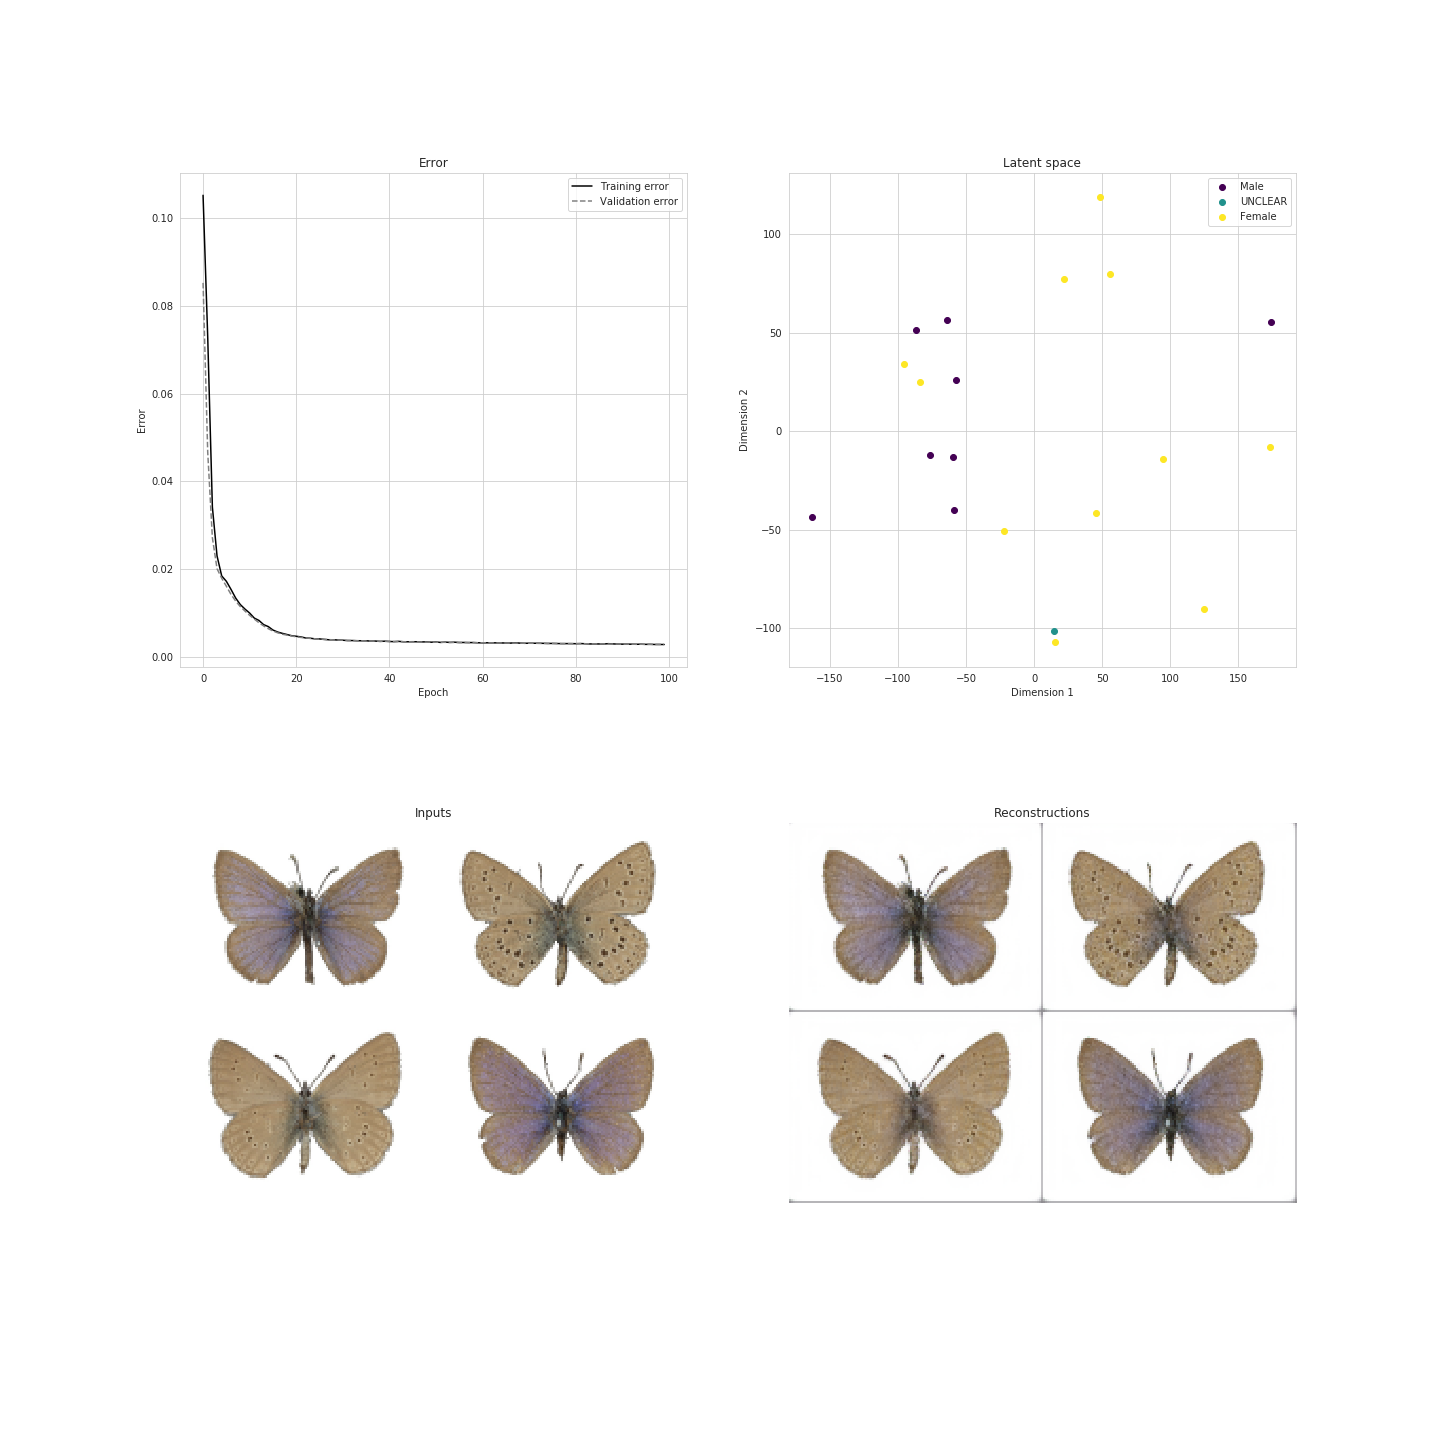

In [7]:
plot(train_losses,valid_losses,x,x_hat,z,batch,epoch,batchSize)

In [62]:
#from: https://stackoverflow.com/questions/48393608/pytorch-network-parameter-calculation

def count_parameters(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name, ':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name, ':', num_param)
            total_param += num_param
    return total_param
print('number of trainable parameters = ',count_parameters(net))

c1.weight : 64x3x7x7 = 9408
c1.bias : 64
c2.weight : 64x64x7x7 = 200704
c2.bias : 64
c3.weight : 128x64x3x3 = 73728
c3.bias : 128
ct1.weight : 128x64x3x3 = 73728
ct1.bias : 64
ct2.weight : 64x64x7x7 = 200704
ct2.bias : 64
ct3.weight : 64x3x7x7 = 9408
ct3.bias : 3
number of trainable parameters =  568067


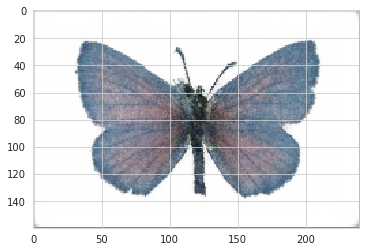

In [16]:
plt.imshow(x_hat[0].permute((1,2,0)).cpu().detach().numpy())

In [101]:


class FFNClassifier(BaseModel):
    def __init__(self,input_shape,hidden_units,output_classes):
        super(FFNClassifier, self).__init__()
        self.batchSize = input_shape[0]
        self.num_features = np.prod(input_shape[1:])
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.num_features,out_features=output_classes),
            #nn.ReLU()#,
            #nn.Linear(in_features=hidden_units,out_features=output_classes)
        )
        
    def forward(self, z):
        z = z.reshape((self.batchSize,self.num_features))
        z = self.classifier(z)
        return torch.softmax(z,dim=1)
classifier_net = FFNClassifier(input_shape=z.shape,hidden_units=100,output_classes=4)
#if cuda:
#    classifier_net = classifier_net.cuda()
    
classifier_net

FFNClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=235008, out_features=4, bias=True)
  )
)

In [102]:
classifier_optimizer = optim.SGD(net.parameters(), lr=0.0001)
classifier_loss = nn.CrossEntropyLoss()

In [107]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(loader.df['Sex'].values)

epochs = 10
net.eval()
c_train_losses = []
c_val_losses = []
for e in range(epochs):
    losses = []
    classifier_net.train()
    loader.trainSet()
    _, numBatches = loader.getIteratorInfo()
    for i in tqdm(range(numBatches)):
        x = loader.getNext()
        y = label_encoder.transform(x.data['Sex'].values)
        x = Variable(torch.from_numpy(x.imgs).float())
        y = Variable(torch.LongTensor(y))
        x = x.permute((0,3,1,2))
        if cuda:
            x = x.cuda()

        outputs = net(x)
        z = outputs['z'].view(batchSize,-1).cpu()
        preds = classifier_net(z)
        loss = classifier_loss(preds, y)
        classifier_optimizer.zero_grad()
        loss.backward()
        classifier_optimizer.step()
        losses += [loss.detach().numpy()]
    print(np.mean(losses))
    c_train_losses += [np.mean(losses)]
    
    losses = []
    classifier_net.eval()
    loader.validationSet()
    _, numBatches = loader.getIteratorInfo()
    for i in tqdm(range(numBatches)):
        x = loader.getNext()
        y = label_encoder.transform(x.data['Sex'].values)
        x = Variable(torch.from_numpy(x.imgs).float())
        y = Variable(torch.LongTensor(y))
        x = x.permute((0,3,1,2))
        if cuda:
            x = x.cuda()

        outputs = net(x)
        z = outputs['z'].view(batchSize,-1).cpu()
        preds = classifier_net(z)
        loss = classifier_loss(preds, y)
        losses += [loss.detach().numpy()]
    print(np.mean(losses))
    c_val_losses += [np.mean(losses)]

1.2125905


1.1159123


KeyboardInterrupt: 

In [106]:
preds,y

(tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 1.0591e-39, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00

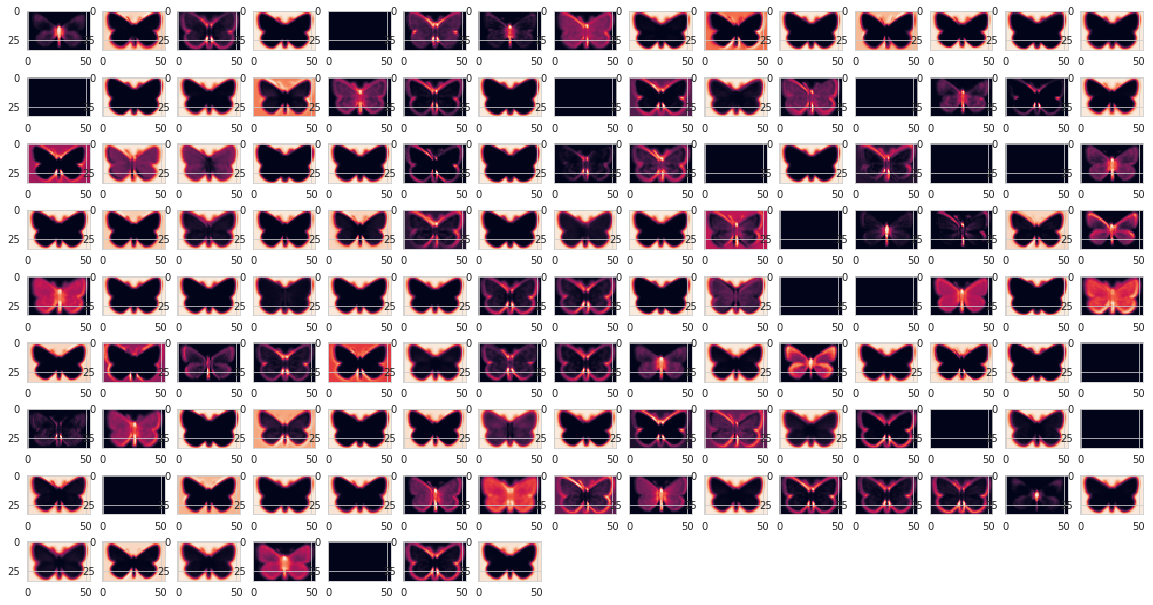

In [72]:
plt.figure(figsize=(20,12))
for i in range(1, 128):
    plt.subplot(10, 15, i)
    plt.imshow(z.mean(axis=0)[i])

In [71]:
z.mean(axis=0).shape

(128, 34, 54)

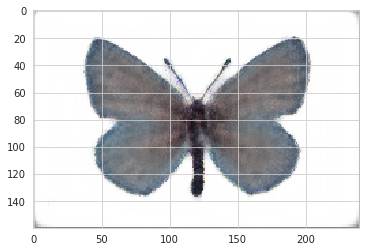

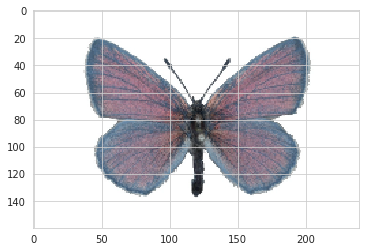

In [204]:
index = 3
plt.imshow(x_hat[index].permute(1,2,0).cpu().detach().numpy())
plt.figure()
plt.imshow(x[index].permute(1,2,0).cpu().detach().numpy())

In [90]:
x_hat[0].shape

torch.Size([3, 160, 240])

In [11]:
cuda

True